# Lab 5: Adding Structure to your Evaluations 

In this lab, you will run experiments:

<img src="images/experiments.png" width="500"/>

to evaluate your agent example. Here are the evaluators you will use:

<img src="images/agent_evaluators.png" width="500"/>

## Importing necessary libraries 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import phoenix as px
from phoenix.evals import OpenAIModel, llm_classify, TOOL_CALLING_PROMPT_TEMPLATE
from phoenix.experiments import run_experiment, evaluate_experiment
from phoenix.experiments.types import Example
from phoenix.experiments.evaluators import create_evaluator
from phoenix.otel import register
import pandas as pd
from utils import get_phoenix_endpoint, run_agent, tools
from utils import process_messages, update_sql_gen_prompt

from datetime import datetime
import json

import os
import nest_asyncio
nest_asyncio.apply()

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access <code>requirements.txt</code>, <code>utils.py</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>

## Creating the Dataset of Test Questions

In [3]:
eval_model=OpenAIModel(model="gpt-4o")

In [4]:
px_client = px.Client()

In [5]:
overall_experiment_questions = [
    {'question': 'What was the most popular product SKU?',
     'sql_result': '   SKU_Coded  Total_Qty_Sold 0    6200700         52262.0', 
     'sql_generated': '```sql\nSELECT SKU_Coded, SUM(Qty_Sold) AS Total_Qty_Sold\nFROM sales\nGROUP BY SKU_Coded\nORDER BY Total_Qty_Sold DESC\nLIMIT 1;\n```'},
    {'question': 'What was the total revenue across all stores?', 
     'sql_result': '   Total_Revenue 0   1.327264e+07', 
     'sql_generated': '```sql\nSELECT SUM(Total_Sale_Value) AS Total_Revenue\nFROM sales;\n```'},
    {'question': 'Which store had the highest sales volume?',
     'sql_result': '   Store_Number  Total_Sales_Volume 0          2970             59322.0', 
     'sql_generated': '```sql\nSELECT Store_Number, SUM(Total_Sale_Value) AS Total_Sales_Volume\nFROM sales\nGROUP BY Store_Number\nORDER BY Total_Sales_Volume DESC\nLIMIT 1;\n```'},
    {'question': 'Create a bar chart showing total sales by store',
     'sql_result': '    Store_Number    Total_Sales 0            880  420302.088397 1           1650  580443.007953 2           4180  272208.118542 3            550  229727.498752 4           1100  497509.528013 5           3300  619660.167018 6           3190  335035.018792 7           2970  836341.327191 8           3740  359729.808228 9           2530  324046.518720 10          4400   95745.620250 11          1210  508393.767785 12           330  370503.687331 13          2750  453664.808068 14          1980  242290.828499 15          1760  350747.617798 16          3410  410567.848126 17           990  378433.018639 18          4730  239711.708869 19          4070  322307.968330 20          3080  495458.238811 21          2090  309996.247965 22          1320  592832.067579 23          2640  308990.318559 24          1540  427777.427815 25          4840  389056.668316 26          2860  132320.519487 27          2420  406715.767402 28           770  292968.918642 29          3520  145701.079372 30           660  343594.978075 31          3630  405034.547846 32          2310  412579.388504 33          2200  361173.288199 34          1870  401070.997685', 
     'sql_generated': '```sql\nSELECT Store_Number, SUM(Total_Sale_Value) AS Total_Sales\nFROM sales\nGROUP BY Store_Number;\n```'},
    {'question': 'What percentage of items were sold on promotion?',
     'sql_result': '   Promotion_Percentage 0              0.625596',
     'sql_generated': "```sql\nSELECT \n    (SUM(CASE WHEN On_Promo = 'Yes' THEN 1 ELSE 0 END) * 100.0) / COUNT(*) AS Promotion_Percentage\nFROM \n    sales;\n```"},
    {'question': 'What was the average transaction value?',
     'sql_result': '   Average_Transaction_Value 0                  19.018132',
     'sql_generated': '```sql\nSELECT AVG(Total_Sale_Value) AS Average_Transaction_Value\nFROM sales;\n```'},
    {'question': 'Create a line chart showing sales in 2021',
     'sql_result': '  sale_month  total_quantity_sold  total_sales_value 0 2021-11-01              43056.0      499984.428193 1 2021-12-01              75724.0      910982.118423', 
     'sql_generated': '```sql\nSELECT MONTH(Sold_Date) AS Month, SUM(Total_Sale_Value) AS Total_Sales\nFROM sales\nWHERE YEAR(Sold_Date) = 2021\nGROUP BY MONTH(Sold_Date)\nORDER BY MONTH(Sold_Date);\n```'}
]

overall_experiment_df = pd.DataFrame(overall_experiment_questions)

now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
# create a dataset consisting of input questions and expected outputs
dataset = px_client.upload_dataset(dataframe=overall_experiment_df, 
                                   dataset_name=f"overall_experiment_inputs-{now}", 
                                   input_keys=["question"], 
                                   output_keys=["sql_result", "sql_generated"])

📤 Uploading dataset...
💾 Examples uploaded: https://s172-29-27-99p6006.lab-aws-production.deeplearning.ai/datasets/RGF0YXNldDox/examples
🗄️ Dataset version ID: RGF0YXNldFZlcnNpb246MQ==


### Link to Phoenix UI

You can open this link to check out the Phoenix UI and the uploaded dataset. You can use the same link to check out the results of the experiment you'll run in this notebook. 

**Note**: 
- Since each notebook of this course runs in an isolated environment, each notebook links to a different Phoenix server. This is why you won't see the projects you've worked on in the previous notebooks. 
- Make sure that the notebook's kernel is running when checking the Phoenix UI. If the link does not open, it might be because the notebook has been open or inactive for a long time. In that case, make sure to refresh the browser, run all previous cells and then check this link. 

In [6]:
print(get_phoenix_endpoint())

https://s172-29-27-99p6006.lab-aws-production.deeplearning.ai/


## Setting up the Evaluators

Let's define the template prompts for the LLM-as-a-judge that will be used to evaluate the clarity of the analysis of tool 2 and the correctness of the entities mentioned in the analysis. For router evals, you will use the template provided by Phoenix.

In [7]:
CLARITY_LLM_JUDGE_PROMPT = """
In this task, you will be presented with a query and an answer. Your objective is to evaluate the clarity 
of the answer in addressing the query. A clear response is one that is precise, coherent, and directly 
addresses the query without introducing unnecessary complexity or ambiguity. An unclear response is one 
that is vague, disorganized, or difficult to understand, even if it may be factually correct.

Your response should be a single word: either "clear" or "unclear," and it should not include any other 
text or characters. "clear" indicates that the answer is well-structured, easy to understand, and 
appropriately addresses the query. "unclear" indicates that the answer is ambiguous, poorly organized, or 
not effectively communicated. Please carefully consider the query and answer before determining your 
response.

After analyzing the query and the answer, you must write a detailed explanation of your reasoning to 
justify why you chose either "clear" or "unclear." Avoid stating the final label at the beginning of your 
explanation. Your reasoning should include specific points about how the answer does or does not meet the 
criteria for clarity.

[BEGIN DATA]
Query: {query}
Answer: {response}
[END DATA]
Please analyze the data carefully and provide an explanation followed by your response.

EXPLANATION: Provide your reasoning step by step, evaluating the clarity of the answer based on the query.
LABEL: "clear" or "unclear"
"""

In [8]:
ENTITY_CORRECTNESS_LLM_JUDGE_PROMPT = """
In this task, you will be presented with a query and an answer. Your objective is to determine whether all 
the entities mentioned in the answer are correctly identified and accurately match those in the query. An 
entity refers to any specific person, place, organization, date, or other proper noun. Your evaluation 
should focus on whether the entities in the answer are correctly named and appropriately associated with 
the context in the query.

Your response should be a single word: either "correct" or "incorrect," and it should not include any 
other text or characters. "correct" indicates that all entities mentioned in the answer match those in the 
query and are properly identified. "incorrect" indicates that the answer contains errors or mismatches in 
the entities referenced compared to the query.

After analyzing the query and the answer, you must write a detailed explanation of your reasoning to 
justify why you chose either "correct" or "incorrect." Avoid stating the final label at the beginning of 
your explanation. Your reasoning should include specific points about how the entities in the answer do or 
do not match the entities in the query.

[BEGIN DATA]
Query: {query}
Answer: {response}
[END DATA]
Please analyze the data carefully and provide an explanation followed by your response.

EXPLANATION: Provide your reasoning step by step, evaluating whether the entities in the answer are 
correct and consistent with the query.
LABEL: "correct" or "incorrect"
"""

The following evaluators are set up to take in as parameters: input, output and expected. Here are the structures and meaning of these parameters:
- **input**: this is the input field of your dataset examples that you just created. It has only one key: "question" (as defined in a previous cell).
- **output**: this is the output field added to your dataset examples, after you apply the task to each example. The structure of this output is defined by the task, which is defined in a subsequent cell (as `run_agent_task`). This task returns a processed version of the agent's messages (you can check `process_messages` in `utils.py`): it is a dictionary that organizes the messages into these keys: "tool_calls", "tool_responses", "final_output", "unchanged_messages" and "path_length".
- **expected**: this is the expected output field of your dataset examples that you created in a previous cell. It has two keys: "sql_result" and "sql_generated".

In [9]:
# evaluator for the router
def function_calling_eval(input: str, output: str) -> float:
    if output is None:
        return 0
    function_calls = output.get("tool_calls")
    if function_calls:
        eval_df = pd.DataFrame({
            "question": [input.get("question")] * len(function_calls),
            "tool_call": function_calls
        })
            
        tool_call_eval = llm_classify(
            data = eval_df,
            template = TOOL_CALLING_PROMPT_TEMPLATE.template[0].template.replace("{tool_definitions}", 
                                                                                 json.dumps(tools).replace("{", '"').replace("}", '"')),
            rails = ['correct', 'incorrect'],
            model=eval_model,
            provide_explanation=True
        )

        tool_call_eval['score'] = tool_call_eval.apply(lambda x: 1 if x['label']=='correct' else 0, axis=1)
        return tool_call_eval['score'].mean()
    else:
        return 0

In [10]:
# evaluator for tool 1: database lookup
def evaluate_sql_result(output, expected) -> bool:    
    if output is None:
        return False
    sql_result = output.get("tool_responses")
    if not sql_result:
        return True
    
    # Find first lookup_sales_data response
    sql_result = next((r for r in sql_result if r.get("tool_name") == "lookup_sales_data"), None)
    if not sql_result:
        return True
        
    # Get the first response
    sql_result = sql_result.get("tool_response", "")

    # Extract just the numbers from both strings
    result_nums = ''.join(filter(str.isdigit, sql_result))
    expected_nums = ''.join(filter(str.isdigit, expected.get("sql_result")))
    return result_nums == expected_nums

In [11]:
# evaluator for tool 2: data analysis
def evaluate_clarity(output: str, input: str) -> bool:
    if output is None:
        return False
    df = pd.DataFrame({"query": [input.get("question")],
                       "response": [output.get("final_output")]})
    response = llm_classify(
        data=df,
        template=CLARITY_LLM_JUDGE_PROMPT,
        rails=["clear", "unclear"],
        model=eval_model,
        provide_explanation=True
    )
    return response['label'] == 'clear'

In [12]:
# evaluator for tool 2: data analysis
def evaluate_entity_correctness(output: str, input: str) -> bool:
    if output is None:
        return False
    df = pd.DataFrame({"query": [input.get("question")], 
                       "response": [output.get("final_output")]})
    response = llm_classify(
        data=df,
        template=ENTITY_CORRECTNESS_LLM_JUDGE_PROMPT,
        rails=["correct", "incorrect"],
        model=eval_model,
        provide_explanation=True
    )
    return response['label'] == 'correct'

In [13]:
# evaluator for tool 3: data visualization   
def code_is_runnable(output: str) -> bool:
    """Check if the code is runnable"""
    if output is None:
        return False
    generated_code = output.get("tool_responses")
    if not generated_code:
        return True
    
    # Find first lookup_sales_data response
    generated_code = next((r for r in generated_code if r.get("tool_name") == "generate_visualization"), None)
    if not generated_code:
        return True
        
    # Get the first response
    generated_code = generated_code.get("tool_response", "")
    generated_code = generated_code.strip()
    generated_code = generated_code.replace("```python", "").replace("```", "")
    try:
        exec(generated_code)
        return True
    except Exception as e:
        return False

## Defining the Task

In [14]:
def run_agent_task(example: Example) -> str:
    print("Starting agent with messages:", example.input.get("question"))
    messages = [{"role": "user", "content": example.input.get("question")}]
    ret = run_agent(messages)
    return process_messages(ret)

## Running the Experiment

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their dynamic, probabilistic nature. Your results might differ from those shown in the video. The warnings are also not printed in this notebook.</p> 

🧪 Experiment started.
📺 View dataset experiments: https://s172-29-27-99p6006.lab-aws-production.deeplearning.ai/datasets/RGF0YXNldDox/experiments
🔗 View this experiment: https://s172-29-27-99p6006.lab-aws-production.deeplearning.ai/datasets/RGF0YXNldDox/compare?experimentId=RXhwZXJpbWVudDox


running tasks |          | 0/7 (0.0%) | ⏳ 00:00<? | ?it/s

Starting agent with messages: What was the most popular product SKU?
Running agent with messages: [{'role': 'user', 'content': 'What was the most popular product SKU?'}]
Added system prompt to messages
Starting router
Received response with tool calls: True
Processing tool calls
Starting router
Received response with tool calls: False
No tool calls, returning final response
Starting agent with messages: What was the total revenue across all stores?
Running agent with messages: [{'role': 'user', 'content': 'What was the total revenue across all stores?'}]
Added system prompt to messages
Starting router
Received response with tool calls: True
Processing tool calls
Starting router
Received response with tool calls: False
No tool calls, returning final response
Starting agent with messages: Which store had the highest sales volume?
Running agent with messages: [{'role': 'user', 'content': 'Which store had the highest sales volume?'}]
Added system prompt to messages
Starting router
Received

running experiment evaluations |          | 0/35 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/2 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

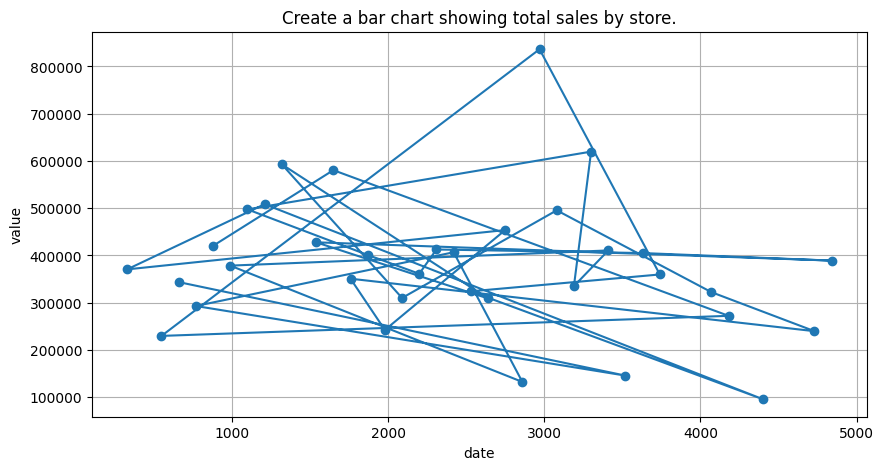

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/2 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s


🔗 View this experiment: https://s172-29-27-99p6006.lab-aws-production.deeplearning.ai/datasets/RGF0YXNldDox/compare?experimentId=RXhwZXJpbWVudDox

Experiment Summary (04/24/25 03:05 PM +0000)
--------------------------------------------
                     evaluator  n  n_scores  avg_score  n_labels  \
0             code_is_runnable  7         7   0.857143         7   
1             evaluate_clarity  7         7   0.857143         0   
2  evaluate_entity_correctness  7         7   1.000000         0   
3          evaluate_sql_result  7         7   0.714286         7   
4        function_calling_eval  7         7   0.142857         0   

              top_2_labels  
0  {'True': 6, 'False': 1}  
1                     None  
2                     None  
3  {'True': 5, 'False': 2}  
4                     None  

Tasks Summary (04/24/25 03:04 PM +0000)
---------------------------------------
   n_examples  n_runs  n_errors
0           7       7         0


In [15]:
experiment = run_experiment(dataset,
                            run_agent_task,
                            evaluators=[function_calling_eval,
                                        evaluate_sql_result, 
                                        evaluate_clarity, 
                                        evaluate_entity_correctness, 
                                        code_is_runnable],
                            experiment_name="Overall Experiment",
                            experiment_description="Evaluating the overall experiment")

## Running the Experiment - Change in Prompt

In [16]:
new_prompt = """
Generate an SQL query based on a prompt. 
Do not reply with anything besides the SQL query.
The prompt is: {prompt}

The available columns are: {columns}
The table name is: {table_name}

Think before you respond.
"""

In [17]:
update_sql_gen_prompt(new_prompt)

🧪 Experiment started.
📺 View dataset experiments: https://s172-29-27-99p6006.lab-aws-production.deeplearning.ai/datasets/RGF0YXNldDox/experiments
🔗 View this experiment: https://s172-29-27-99p6006.lab-aws-production.deeplearning.ai/datasets/RGF0YXNldDox/compare?experimentId=RXhwZXJpbWVudDoy


running tasks |          | 0/7 (0.0%) | ⏳ 00:00<? | ?it/s

Starting agent with messages: What was the most popular product SKU?
Running agent with messages: [{'role': 'user', 'content': 'What was the most popular product SKU?'}]
Added system prompt to messages
Starting router
Received response with tool calls: True
Processing tool calls
Starting router
Received response with tool calls: False
No tool calls, returning final response
Starting agent with messages: What was the total revenue across all stores?
Running agent with messages: [{'role': 'user', 'content': 'What was the total revenue across all stores?'}]
Added system prompt to messages
Starting router
Received response with tool calls: True
Processing tool calls
Starting router
Received response with tool calls: False
No tool calls, returning final response
Starting agent with messages: Which store had the highest sales volume?
Running agent with messages: [{'role': 'user', 'content': 'Which store had the highest sales volume?'}]
Added system prompt to messages
Starting router
Received

running experiment evaluations |          | 0/35 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/2 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

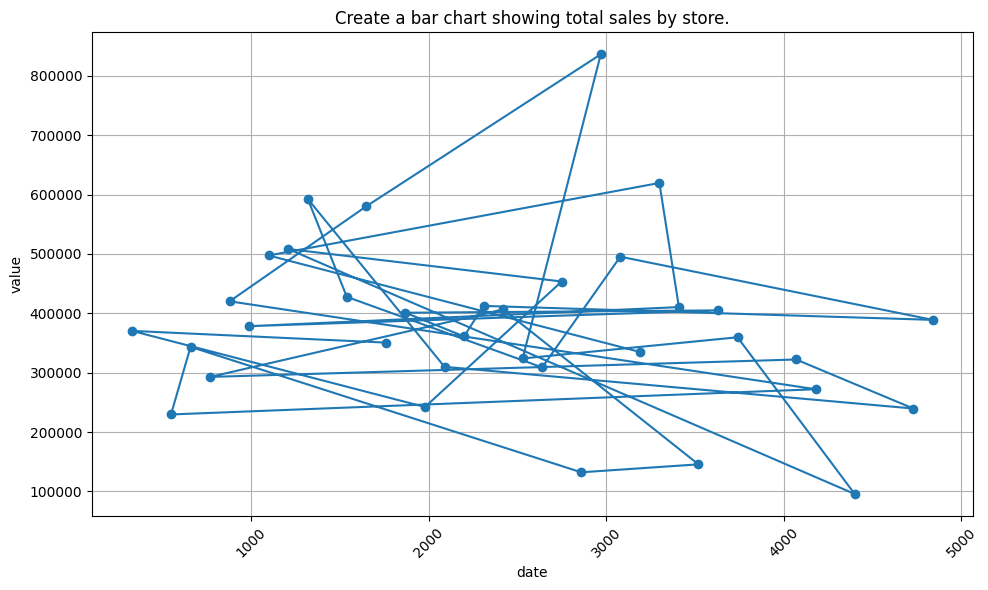

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/2 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s


🔗 View this experiment: https://s172-29-27-99p6006.lab-aws-production.deeplearning.ai/datasets/RGF0YXNldDox/compare?experimentId=RXhwZXJpbWVudDoy

Experiment Summary (04/24/25 03:06 PM +0000)
--------------------------------------------
                     evaluator  n  n_scores  avg_score  n_labels  \
0             code_is_runnable  7         7   0.857143         7   
1             evaluate_clarity  7         7   0.857143         0   
2  evaluate_entity_correctness  7         7   1.000000         0   
3          evaluate_sql_result  7         7   0.714286         7   
4        function_calling_eval  7         7   0.142857         0   

              top_2_labels  
0  {'True': 6, 'False': 1}  
1                     None  
2                     None  
3  {'True': 5, 'False': 2}  
4                     None  

Tasks Summary (04/24/25 03:06 PM +0000)
---------------------------------------
   n_examples  n_runs  n_errors
0           7       7         0


In [18]:
experiment = run_experiment(dataset,
                            run_agent_task,
                            evaluators=[function_calling_eval, 
                                        evaluate_sql_result, 
                                        evaluate_clarity, 
                                        evaluate_entity_correctness,
                                        code_is_runnable],
                            experiment_name="Overall Experiment v2",
                            experiment_description="Evaluating the overall experiment, with changes to sql prompt")

## Optional - Playground in Phoenix

Alternatively, you can try the playground feature in Phoenix UI to change the prompt and compare the results. You can run the following cells to get the prompt that you can input in the UI.

**Note** that this is an optional part, and the OpenAI key is only provided in this notebook and not in the Phoenix server. 

In [19]:
from utils import get_sql_gen_prompt

In [20]:
print(get_sql_gen_prompt())


Generate an SQL query based on a prompt. Do not reply with anything besides the SQL query.
The prompt is: question

The available columns are: Index(['Store_Number', 'SKU_Coded', 'Product_Class_Code', 'Sold_Date',
       'Qty_Sold', 'Total_Sale_Value', 'On_Promo'],
      dtype='object')
The table name is: sales



<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

<p> 📒 &nbsp; For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>

</div>